# Taller: Análisis de Tendencias para Google y Microsoft

En este taller analizaremos los datos de precios para Google y Microsoft (símbolos `GOOGL` y `MSFT`) utilizando la base `prices.csv`.

El objetivo es:

- Filtrar los datos para estas dos empresas.
- Convertir la columna de fecha de forma robusta, ya que diferentes empresas pueden tener distintos formatos de fecha.
- Ordenar los datos por fecha.
- Aplicar un suavizado (media móvil) para ver la tendencia general durante el periodo (máximo 2016).
- Generar una gráfica final que integre un storytelling (Setup, Conflict y Resolution) en el análisis de la tendencia.

Responde las siguientes preguntas en el proceso:

1. ¿Cuáles son el primer y último año del dataset para las empresas seleccionadas?
2. ¿Cuántas observaciones tienes para cada empresa?
3. ¿Qué tendencia se observa tras aplicar el suavizado?


In [1]:
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/time_series.zip
!unzip time_series.zip
!cp -r time_series/* ./

--2025-04-09 01:33:35--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/time_series.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/time_series.zip [following]
--2025-04-09 01:33:35--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/time_series.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15602616 (15M) [application/zip]
Saving to: ‘time_series.zip’

time_series.zip     100%[===================>]  14.88M  --.-KB/s    in 0.08s   

2025-04-09 01:33:36 (180 MB/s) - ‘time_

## Paso 1: Carga del Dataset y Filtrado de Empresas

Carga el archivo `prices.csv` y filtra únicamente los datos correspondientes a Google y Microsoft.

Pregunta: ¿Qué cantidad de observaciones tienes para cada empresa después del filtrado?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import pandas as pd

%matplotlib inline

prices_df = pd.read_csv('prices.csv')

TablaFiltrada = prices_df[prices_df['symbol'].isin(['GOOGL', 'MSFT'])]

ObservacionesEmpresa = TablaFiltrada.groupby('symbol')['date'].count()

print("Observaciones por Empresa:")
print(ObservacionesEmpresa)

Observaciones por Empresa:
symbol
GOOGL    1762
MSFT     1762
Name: date, dtype: int64


Vemos que el número de observaciones por empresa es 1762 para ambas

## Paso 2: Conversión Robust a Formato Datetime

Dado que diferentes empresas podrían tener formatos de fecha distintos, convertiremos la columna `date` usando `pd.to_datetime` sin forzar un formato fijo.

Elimina las filas que no se puedan convertir (donde la fecha es `NaT`).

Pregunta: ¿Cuántas filas se descartan por tener fechas inválidas?

In [3]:
TablaFiltrada['date'] = pd.to_datetime(TablaFiltrada['date'], errors='coerce')

<ipython-input-3-c6711716cd0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TablaFiltrada['date'] = pd.to_datetime(TablaFiltrada['date'], errors='coerce')


In [4]:
invalid_dates_count = TablaFiltrada['date'].isna().sum()

filtered_df = TablaFiltrada.dropna(subset=['date'])

print(f"Se descartaron {invalid_dates_count} filas por tener fechas inválidas.")

Se descartaron 0 filas por tener fechas inválidas.


Como tal se descartan 0 filas por fechas inválidas

## Paso 3: Ordenar Datos y Análisis Inicial

Ordena los datos por la columna `date` para cada empresa y determina:

- ¿Cuál es el primer año y el último año para cada empresa?
- ¿Cuántas observaciones hay en total para el periodo (recordando que la fecha máxima es 2016)?

In [5]:
TablaFiltrada= filtered_df.sort_values(by=['date'])

In [6]:
def get_first_last_year(df):
    first_year = df['date'].min().year
    last_year = df['date'].max().year
    return first_year, last_year

In [7]:
TablaFiltrada['date'] = pd.to_datetime(TablaFiltrada['date'], errors='coerce')
filtered_df = TablaFiltrada.dropna(subset=['date'])
filtered_df = filtered_df.sort_values(by=['date'])

In [8]:
google_first_year, google_last_year = get_first_last_year(filtered_df[filtered_df['symbol'] == 'GOOGL'])
microsoft_first_year, microsoft_last_year = get_first_last_year(filtered_df[filtered_df['symbol'] == 'MSFT'])

In [9]:
print(f"Primer año para Google: {google_first_year}")
print(f"Último año para Google: {google_last_year}")
print(f"Primer año para Microsoft: {microsoft_first_year}")
print(f"Último año para Microsoft: {microsoft_last_year}")

Primer año para Google: 2010
Último año para Google: 2016
Primer año para Microsoft: 2010
Último año para Microsoft: 2016


In [10]:
filtered_df = filtered_df[filtered_df['date'].dt.year <= 2016]

In [11]:
total_observations = len(filtered_df)

print(f"Total de observaciones hasta 2016: {total_observations}")

Total de observaciones hasta 2016: 3524


Tnenemos que el primer y último año para ambos es el 2010 y 2016, y aparte las observaciones son 3524.


## Paso 4: Visualización Inicial (Setup) – Gráfica de Precios de Cierre

Construye una gráfica inicial que muestre el precio de cierre a lo largo del tiempo para Google y Microsoft.

Utiliza un título multi-línea que comunique la etapa Setup. Por ejemplo:

```
Setup: Serie de Precios sin Suavizado
Datos originales para Google y Microsoft
CONFLICT: IDENTIFICAR MOVIMIENTOS ATÍPICOS
```

Pregunta: ¿Qué diferencias notas entre las series de ambas empresas?

In [12]:
filtro_pivot=pd.pivot_table(TablaFiltrada, values="close", index="date", columns="symbol")

In [13]:
filtro_pivot

symbol,GOOGL,MSFT
date,,
2010-01-04,626.750011,30.950001
2010-01-05,623.990017,30.959999
2010-01-06,608.260035,30.770000
2010-01-07,594.100015,30.450001
2010-01-08,602.020005,30.660000
...,...,...
2016-12-23,807.799988,63.240002
2016-12-27,809.929993,63.279999
2016-12-28,804.570007,62.990002


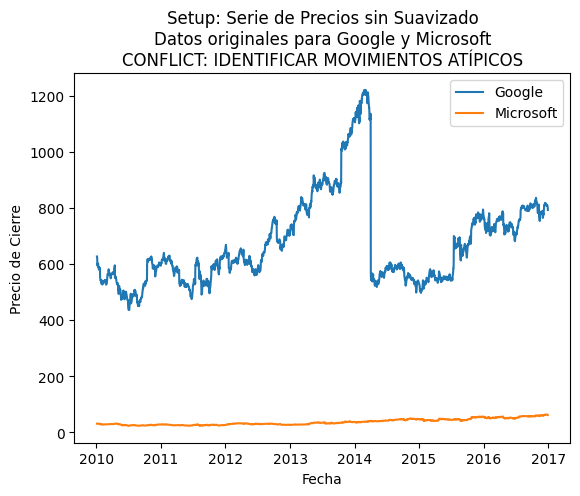

In [14]:
plt.plot(filtro_pivot.index, filtro_pivot['GOOGL'], label='Google')
plt.plot(filtro_pivot.index, filtro_pivot['MSFT'], label='Microsoft')
plt.title('Setup: Serie de Precios sin Suavizado\nDatos originales para Google y Microsoft\nCONFLICT: IDENTIFICAR MOVIMIENTOS ATÍPICOS')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

In [15]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='date', ylabel='close'>

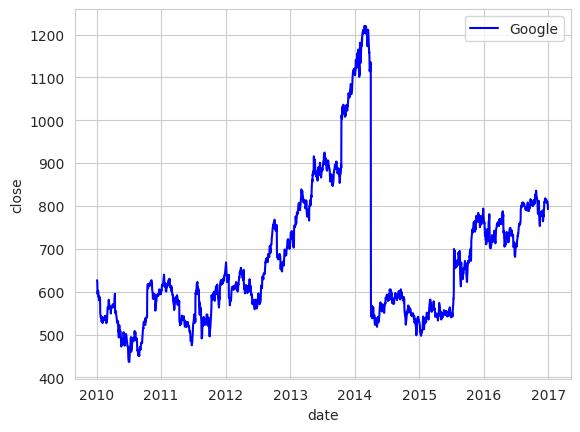

In [16]:
sns.lineplot(x='date', y='close', data=filtered_df[filtered_df['symbol'] == 'GOOGL'], label='Google', color='blue')

<Axes: xlabel='date', ylabel='close'>

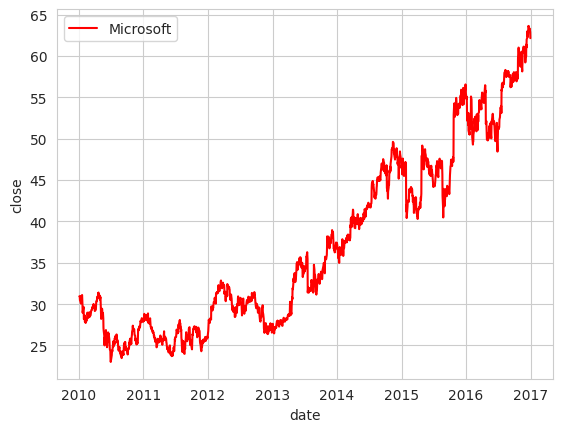

In [17]:
sns.lineplot(x='date', y='close', data=filtered_df[filtered_df['symbol'] == 'MSFT'], label='Microsoft', color='red')

## Paso 5: Aplicar Suavizado (Resolution) – Media Móvil y Análisis de Tendencia

Aplica un suavizado a las series (por ejemplo, una media móvil) para resaltar la tendencia general en los datos.

Pregunta: ¿Qué ventana de suavizado (en días) consideras adecuada para observar la tendencia en el año 2016? ¿Cómo se comporta la tendencia para Google y Microsoft después de suavizar los datos?

In [18]:
filtro_pivot['GOOGL_MA'] = filtro_pivot['GOOGL'].rolling(window=90).mean()
filtro_pivot['MSFT_MA'] = filtro_pivot['MSFT'].rolling(window=90).mean()

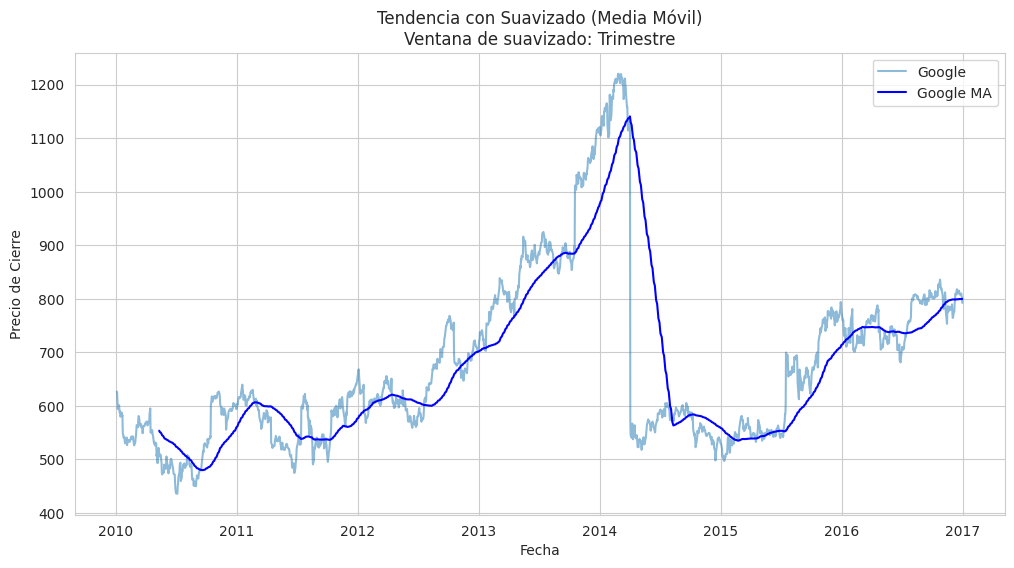

In [19]:
plt.figure(figsize=(12, 6))
window_size = 90
plt.plot(filtro_pivot.index, filtro_pivot['GOOGL'], label='Google', alpha=0.5)
plt.plot(filtro_pivot.index, filtro_pivot['GOOGL_MA'], label='Google MA', color='blue')
plt.title('Tendencia con Suavizado (Media Móvil)\nVentana de suavizado: Trimestre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

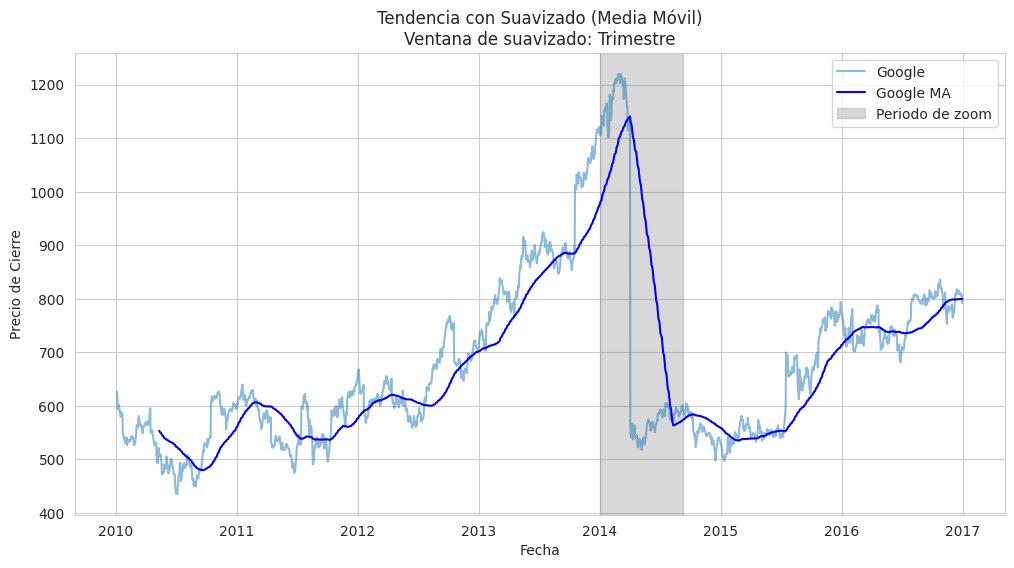

In [20]:
inicio_zoom = '2014-01-01'
fin_zoom = '2014-09-09'

# Convert inicio_zoom and fin_zoom to datetime objects
inicio_zoom = pd.to_datetime(inicio_zoom)
fin_zoom = pd.to_datetime(fin_zoom)

plt.figure(figsize=(12, 6))
# Plot the data first
plt.plot(filtro_pivot.index, filtro_pivot['GOOGL'], label='Google', alpha=0.5)
plt.plot(filtro_pivot.index, filtro_pivot['GOOGL_MA'], label='Google MA', color='blue')

# Then highlight the zoom period
plt.axvspan(inicio_zoom, fin_zoom, color='grey', alpha=0.3, label='Periodo de zoom')

plt.title('Tendencia con Suavizado (Media Móvil)\nVentana de suavizado: Trimestre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()

plt.show()

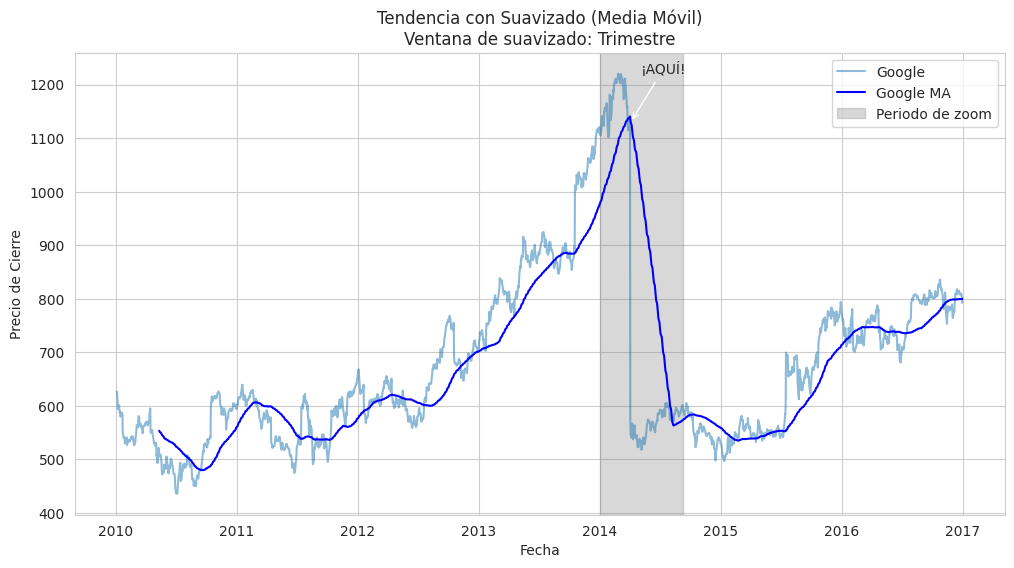

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import pandas as pd

%matplotlib inline

inicio_zoom = '2014-01-01'
fin_zoom = '2014-09-09'

# Convert inicio_zoom and fin_zoom to datetime objects
inicio_zoom = pd.to_datetime(inicio_zoom)
fin_zoom = pd.to_datetime(fin_zoom)

plt.figure(figsize=(12, 6))
# Plot the data first
plt.plot(filtro_pivot.index, filtro_pivot['GOOGL'], label='Google', alpha=0.5)
plt.plot(filtro_pivot.index, filtro_pivot['GOOGL_MA'], label='Google MA', color='blue')

# Then highlight the zoom period
plt.axvspan(inicio_zoom, fin_zoom, color='grey', alpha=0.3, label='Periodo de zoom')

# Add annotation with arrow
punto_x = pd.to_datetime('2014-04-04')  # Fecha del punto a señalar
punto_y = filtro_pivot.loc[punto_x, 'GOOGL_MA'] # Valor de Google MA en esa fecha
plt.annotate('¡AQUÍ!', xy=(punto_x, punto_y), xytext=(punto_x + pd.Timedelta(days=30), punto_y + 90), # Posición del texto
             arrowprops=dict(facecolor='red', arrowstyle='->')) # Propiedades de la flecha

plt.title('Tendencia con Suavizado (Media Móvil)\nVentana de suavizado: Trimestre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()

plt.show()

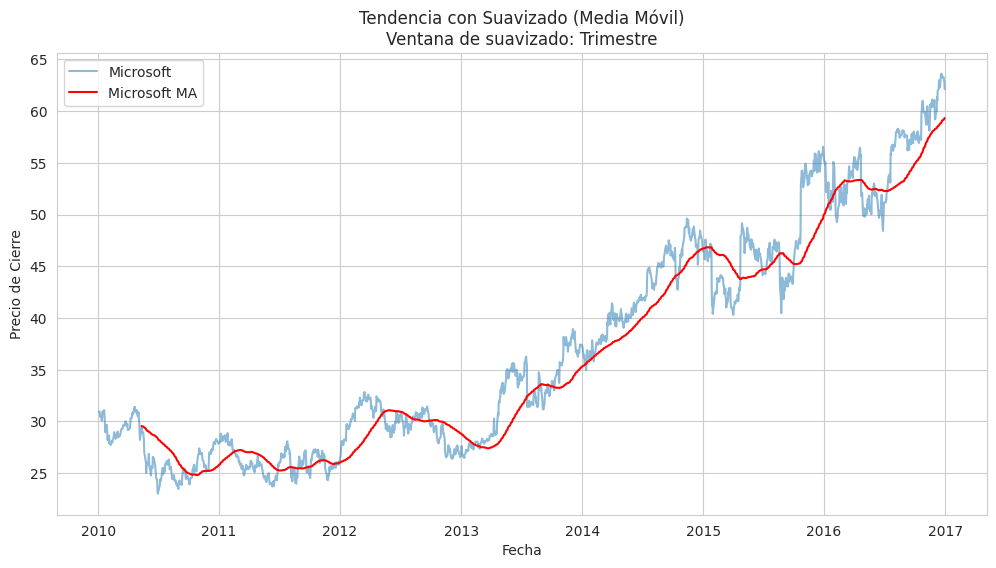

In [22]:
plt.figure(figsize=(12, 6))
window_size = 90
plt.plot(filtro_pivot.index, filtro_pivot['MSFT'], label='Microsoft', alpha=0.5)
plt.plot(filtro_pivot.index, filtro_pivot['MSFT_MA'], label='Microsoft MA', color='red')
plt.title('Tendencia con Suavizado (Media Móvil)\nVentana de suavizado: Trimestre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

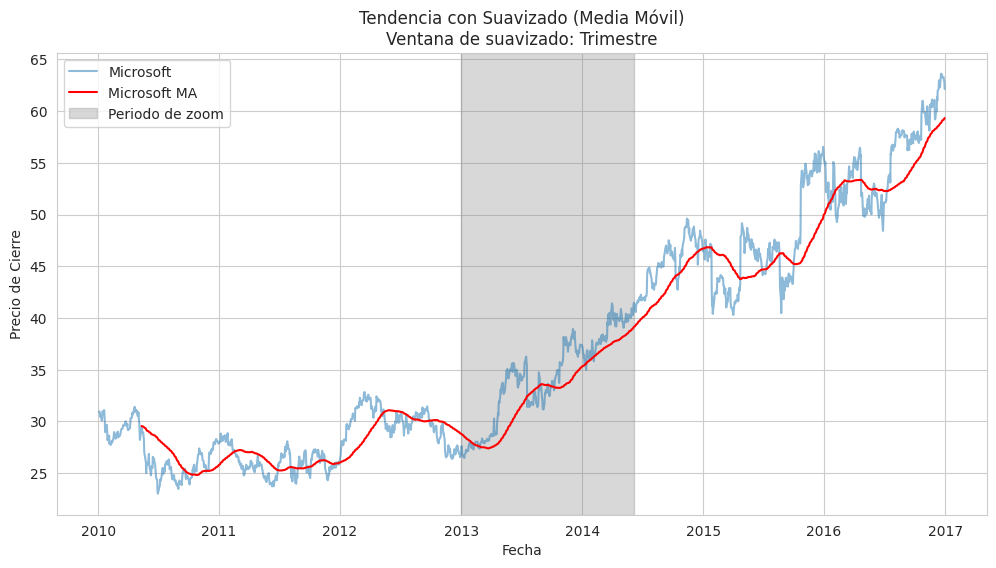

In [26]:
inicio_zoom = '2013-01-01'
fin_zoom = '2014-06-06'

# Convert inicio_zoom and fin_zoom to datetime objects
inicio_zoom = pd.to_datetime(inicio_zoom)
fin_zoom = pd.to_datetime(fin_zoom)

plt.figure(figsize=(12, 6))
# Plot the data first
plt.plot(filtro_pivot.index, filtro_pivot['MSFT'], label='Microsoft', alpha=0.5)
plt.plot(filtro_pivot.index, filtro_pivot['MSFT_MA'], label='Microsoft MA', color='red')

# Then highlight the zoom period
plt.axvspan(inicio_zoom, fin_zoom, color='grey', alpha=0.3, label='Periodo de zoom')

plt.title('Tendencia con Suavizado (Media Móvil)\nVentana de suavizado: Trimestre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

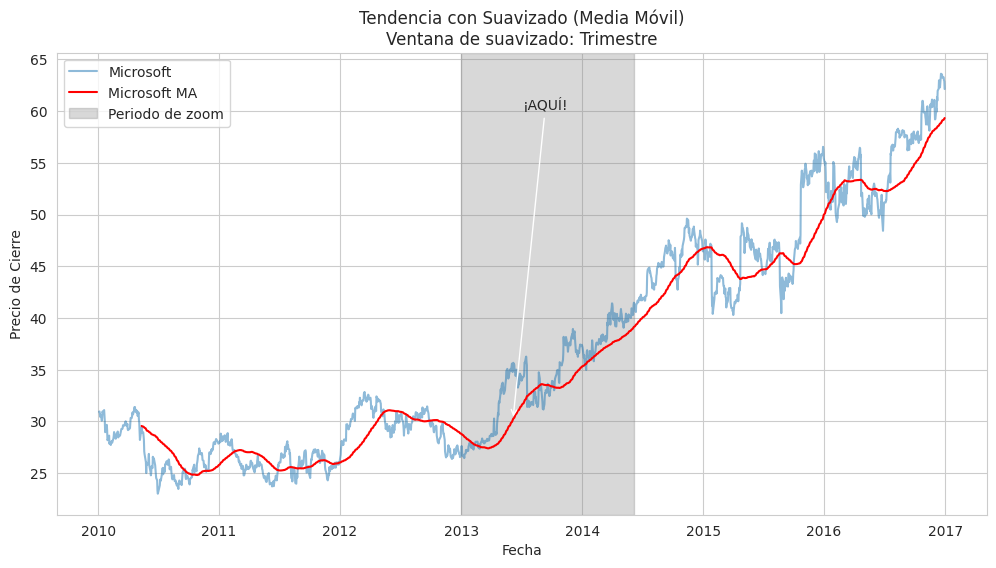

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import pandas as pd

%matplotlib inline

inicio_zoom = '2013-01-01'
fin_zoom = '2014-06-06'

# Convert inicio_zoom and fin_zoom to datetime objects
inicio_zoom = pd.to_datetime(inicio_zoom)
fin_zoom = pd.to_datetime(fin_zoom)

plt.figure(figsize=(12, 6))
# Plot the data first
plt.plot(filtro_pivot.index, filtro_pivot['MSFT'], label='Microsoft', alpha=0.5)
plt.plot(filtro_pivot.index, filtro_pivot['MSFT_MA'], label='Microsoft MA', color='red')

# Then highlight the zoom period
plt.axvspan(inicio_zoom, fin_zoom, color='grey', alpha=0.3, label='Periodo de zoom')

# Add annotation with arrow
punto_x = pd.to_datetime('2013-06-06')  # Fecha del punto a señalar
punto_y = filtro_pivot.loc[punto_x, 'MSFT_MA'] # Valor de Google MA en esa fecha
plt.annotate('¡AQUÍ!', xy=(punto_x, punto_y), xytext=(punto_x + pd.Timedelta(days=30), punto_y + 30), # Posición del texto
             arrowprops=dict(facecolor='red', arrowstyle='->')) # Propiedades de la flecha

plt.title('Tendencia con Suavizado (Media Móvil)\nVentana de suavizado: Trimestre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()

plt.show()

## Conclusiones y Entrega

En este taller se ha realizado lo siguiente:

- Se cargaron los datos y se filtraron únicamente para las empresas Google y Microsoft.
- Se convirtió la columna `date` de forma robusta, eliminando filas con fechas inválidas.
- Se ordenaron los datos cronológicamente y se obtuvieron información general (primer y último año, número de observaciones por empresa).
- Se construyó una gráfica de storytelling con dos etapas:
  - **Setup:** Visualización inicial de los precios de cierre originales para Google y Microsoft.
  - **Resolution:** Aplicación de un suavizado (media móvil) para resaltar la tendencia general.

Tu entrega final debe incluir las gráficas generadas y una breve explicación de cada paso, respondiendo las preguntas planteadas en el taller.